# Machine Learning Trading Bot

## Background
- Three machine learning models were utilized to train and predict the trading data sourced from Alpaca API. 
- The target was determined to be the entry price plus 3 times the Average True Range(ATR): '1'.
- The stop was determined to be the entry price minus the Average True Range (ATR): '-1'. 
- Support Vector Machine (SVM), Decision Tree models, and Stochasstic Gradient Descent (SGD) were applied to this data.

In [1]:
# initial imports
from pathlib import Path 
import numpy as np
import matplotlib.pyplot as plt 
from finta import TA

import pandas as pd 
import hvplot.pandas
from pandas.tseries.offsets import DateOffset

import alpaca_trade_api as tradeapi

from sklearnex import patch_sklearn
patch_sklearn()
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn import svm

from imblearn.under_sampling import RandomUnderSampler

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
# import alpaca
# from alpaca.data.historical import CryptoHistoricalDataClient
# from alpaca.data.requests import CryptoBarsRequest
# from alpaca.data.timeframe import TimeFrame
# from datetime import datetime
# from dateutil.relativedelta import relativedelta

# ticker = "ETH/USD"
# time_diff = datetime.now() - relativedelta(days=200)

# # Alpaca Market Data Client
# data_client = CryptoHistoricalDataClient()

# # Defining Bar data request parameters
# request_params = CryptoBarsRequest(
#     symbol_or_symbols=[ticker],
#     timeframe=TimeFrame(5, alpaca.data.timeframe.TimeFrameUnit.Minute),
#     start=time_diff
# )

# # Get the bar data from Alpaca
# signals_df = data_client.get_crypto_bars(request_params).df

# signals_df.reset_index(level='symbol', inplace=True)
# signals_df.drop(columns=["symbol"], inplace=True)

# signals_df

In [3]:
# # save copy
# signals_df.to_csv("./ETH_time_series.csv", index="timestamp")

# signals_df

### Download stock time-series data from Alpaca API into Pandas DataFrame

In [27]:
# THE FOLLOWING IS TO REQUEST IN DATA USING THE ALPACA_API
# API credentials
API_KEY = 'PKD98H4EZF8YRDLUZ5I2'
SECRET_KEY = 'b5ZbNnx35m3uaB6vRnrU7TLQlgEfDw0bKf1Y8Zsm'
API_BASE_URL = "https://paper-api.alpaca.markets"

# Create a connection to the API 
api = tradeapi.REST(API_KEY, SECRET_KEY, API_BASE_URL, api_version="v2")
    
# Set the ticket symbol and the number of shares to buy
ticker = "SPY"

# Make API call
signals_df = api.get_bars(ticker, "4hour", "2022-08-01", "2023-08-30", adjustment='raw').df

# # Save the DataFrame with the date index
# signals_df.to_csv('SPY_15min_time_series_df.csv')

# create a seperate dataframe for signals
signals_df

,open,high,low,close,volume,trade_count,vwap
timestamp,,,,,,,
2015-12-01 08:00:00+00:00,209.4300,209.6500,209.0700,209.440,129269,309,209.346950
2015-12-01 12:00:00+00:00,209.4500,210.3900,209.1100,209.890,33764235,125384,209.753806
2015-12-01 16:00:00+00:00,209.9000,210.2000,209.4700,210.045,35820667,140173,209.748665
2015-12-01 20:00:00+00:00,210.0500,210.8200,210.0250,210.500,27992916,71753,210.343665
2015-12-02 00:00:00+00:00,210.5100,210.6300,210.4900,210.620,80281,119,210.578613
...,...,...,...,...,...,...,...
2023-08-29 20:00:00+00:00,449.1500,449.6600,443.0222,449.450,9052326,7178,448.180082
2023-08-30 08:00:00+00:00,449.3200,449.3300,448.3300,448.790,315780,1624,448.814741
2023-08-30 12:00:00+00:00,448.9188,451.6200,448.3104,451.060,27280581,226133,450.264480


In [31]:
type(signals_df.index[0])

pandas._libs.tslibs.timestamps.Timestamp

### Read in stock time-series data from .csv file into Pandas DataFrame

In [5]:
# # Set ticker
# ticker = "AAPL"

# # Load the DataFrame from a CSV file
# signals_df = pd.read_csv('AAPL_time_series_df.csv', index_col="timestamp")

# # Convert the first column (assuming it contains datetime-like values) to DatetimeIndex
# signals_df.index = pd.to_datetime(signals_df.index)

# # Define NYSE regular trading hours
# nyse_opening_time = pd.Timestamp("09:30:00")
# nyse_closing_time = pd.Timestamp("16:00:00")

# # Filter the DataFrame to include only data within NYSE regular trading hours
# signals_df = signals_df.between_time(nyse_opening_time.time(), nyse_closing_time.time())

# # save copy
# signals_df.to_csv("../data/SPY_time_series.csv", index="timestamp")

signals_df

,open,high,low,close,volume,trade_count,vwap
timestamp,,,,,,,
2022-04-01 04:01:00+00:00,453.84,453.84,453.840,453.84,400,2,453.840000
2022-04-01 04:45:00+00:00,453.40,453.40,453.400,453.40,682,5,453.400308
2022-04-01 04:52:00+00:00,453.38,453.38,453.380,453.38,100,1,453.380000
2022-04-01 05:59:00+00:00,453.00,453.00,453.000,453.00,2094,5,453.000091
2022-04-01 06:01:00+00:00,452.90,453.00,452.900,453.00,800,3,452.937500
...,...,...,...,...,...,...,...
2023-08-30 23:55:00+00:00,451.03,451.03,451.030,451.03,777,26,451.030193
2023-08-30 23:56:00+00:00,451.03,451.03,451.030,451.03,803,15,451.031320
2023-08-30 23:57:00+00:00,451.03,451.06,451.030,451.06,823,7,451.042479


<Axes: title={'center': 'SPY Closing Prices'}, xlabel='Timestamp', ylabel='Closing Price'>

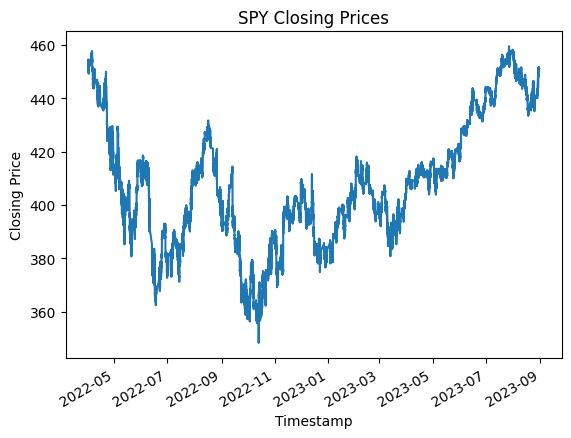

In [6]:
# plot closing prices
signals_df['close'].plot(title=f'{ticker} Closing Prices', xlabel="Timestamp", ylabel='Closing Price')
# plt.savefig(f'{ticker}_closing_prices', facecolor='white', edgecolor='white', transparent='false')

### Add Features (Techincal Analysis Indicators) to the DataFrame

In [7]:
# continuous features (techinal indicators) may be used
features = ["volume", "trade_count", "vwap", "9EMA", "20EMA", "50EMA", "200SMA", "ATR", "RSI", "BB_UPPER", "BB_LOWER", "MACD"]

#  Setup EMAs for crosses
longest_MA_window = 200
signals_df["9EMA"] = TA.EMA(signals_df, 9)
signals_df["20EMA"] = TA.EMA(signals_df, 20)
signals_df["50EMA"] = TA.EMA(signals_df, 50)
signals_df["200SMA"] = TA.SMA(signals_df, longest_MA_window)

# Setup Indicators
signals_df["ATR"] = TA.ATR(signals_df)
bbands_df = TA.BBANDS(signals_df)
macd_df = TA.MACD(signals_df)
signals_df["RSI"] = TA.RSI(signals_df)

# join macd and bbands Dataframes to signals_df
bbands_df = pd.concat([bbands_df, macd_df], axis=1)
signals_df = pd.concat([signals_df, bbands_df], axis=1)
signals_df.drop(columns=["SIGNAL", "BB_MIDDLE"], inplace=True)

# Exit is the labeled target for ML, Exit Price is for use in Pnl Metrics
signals_df["Entry Price"] = 0
signals_df["Entry Time"] = 0

signals_df["Exit Price"] = 0
signals_df["Exit Time"] = 0
signals_df["Exit"] = 0

# Review DataFrame
signals_df

,open,high,low,close,volume,trade_count,vwap,9EMA,20EMA,50EMA,...,ATR,RSI,BB_UPPER,BB_LOWER,MACD,Entry Price,Entry Time,Exit Price,Exit Time,Exit
timestamp,,,,,,,,,,,,,,,,,,,,,
2022-04-01 04:01:00+00:00,453.84,453.84,453.840,453.84,400,2,453.840000,453.840000,453.840000,453.840000,...,NaN,NaN,NaN,NaN,0.000000,0,0,0,0,0
2022-04-01 04:45:00+00:00,453.40,453.40,453.400,453.40,682,5,453.400308,453.595556,453.609000,453.615600,...,NaN,0.000000,NaN,NaN,-0.009872,0,0,0,0,0
2022-04-01 04:52:00+00:00,453.38,453.38,453.380,453.38,100,1,453.380000,453.507213,453.524913,453.533905,...,NaN,0.000000,NaN,NaN,-0.013199,0,0,0,0,0
2022-04-01 05:59:00+00:00,453.00,453.00,453.000,453.00,2094,5,453.000091,453.335393,453.373378,453.392315,...,NaN,0.000000,NaN,NaN,-0.028108,0,0,0,0,0
2022-04-01 06:01:00+00:00,452.90,453.00,452.900,453.00,800,3,452.937500,453.235621,453.283061,453.307452,...,NaN,0.000000,NaN,NaN,-0.035618,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-30 23:55:00+00:00,451.03,451.03,451.030,451.03,777,26,451.030193,451.049979,451.076070,451.124296,...,0.025000,39.636512,451.160603,451.004397,-0.030226,0,0,0,0,0
2023-08-30 23:56:00+00:00,451.03,451.03,451.030,451.03,803,15,451.031320,451.045984,451.071682,451.120598,...,0.023571,39.636512,451.160020,450.997980,-0.030202,0,0,0,0,0
2023-08-30 23:57:00+00:00,451.03,451.06,451.030,451.06,823,7,451.042479,451.048787,451.070569,451.118222,...,0.024286,45.709798,451.151089,450.998911,-0.027446,0,0,0,0,0


In [8]:
# Define NYSE regular trading hours
nyse_opening_time = pd.Timestamp("09:30:00")
nyse_closing_time = pd.Timestamp("16:00:00")

# Filter the DataFrame to include only data within NYSE regular trading hours
signals_df = signals_df.between_time(nyse_opening_time.time(), nyse_closing_time.time())

# Review DataFrame
signals_df

,open,high,low,close,volume,trade_count,vwap,9EMA,20EMA,50EMA,...,ATR,RSI,BB_UPPER,BB_LOWER,MACD,Entry Price,Entry Time,Exit Price,Exit Time,Exit
timestamp,,,,,,,,,,,,,,,,,,,,,
2022-04-01 09:30:00+00:00,453.990,454.36,453.99,454.36,562,10,454.250872,453.992443,453.932919,453.888128,...,0.184286,62.036288,454.300550,453.538450,0.046136,0,0,0,0,0
2022-04-01 09:31:00+00:00,454.380,454.38,454.34,454.34,1119,6,454.344227,454.061955,453.971818,453.907866,...,0.186429,61.370256,454.358844,453.512156,0.072196,0,0,0,0,0
2022-04-01 09:32:00+00:00,454.330,454.34,454.33,454.34,5652,26,454.330464,454.117564,454.006989,453.926659,...,0.169286,61.370256,454.410102,453.491898,0.091786,0,0,0,0,0
2022-04-01 09:33:00+00:00,454.340,454.39,454.34,454.39,425,5,454.379976,454.172051,454.043566,453.946723,...,0.172143,62.536442,454.472309,453.473691,0.110033,0,0,0,0,0
2022-04-01 09:34:00+00:00,454.330,454.33,454.30,454.32,10809,28,454.324391,454.201641,454.069958,453.962821,...,0.176429,59.813982,454.511903,453.466097,0.117539,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-30 15:56:00+00:00,450.911,450.94,450.80,450.81,64908,568,450.879684,450.844208,450.828386,450.662815,...,0.160579,50.796093,451.221035,450.644315,0.051302,0,0,0,0,0
2023-08-30 15:57:00+00:00,450.820,450.85,450.77,450.85,53046,521,450.802812,450.845366,450.830445,450.670155,...,0.158079,52.394147,451.217530,450.636820,0.047650,0,0,0,0,0
2023-08-30 15:58:00+00:00,450.850,450.97,450.83,450.86,68479,593,450.918636,450.848293,450.833260,450.677600,...,0.160221,52.806811,451.200396,450.632954,0.045044,0,0,0,0,0


In [9]:
# Disable the warning
pd.options.mode.chained_assignment = None  # "None" suppresses the warning

### Create Volatility Based Targets and Stops

In [10]:
# here we create the exit column, our "y", for use in supervised ML
# How many rows are in the signals_df? for use in modifying DataFrame
num_rows_in_df = signals_df.shape[0]

# reward:risk ratio
reward = 6
risk = 2

# we also figure out our exit price
# hitting target price before the stop price signals a win and will be 1
# hitting stop price before hitting the target price signals a loss and will be -1
# loop thru the dataframe, from the longest_MA_window to the end (num_rows_in_df) to avoid NaN values
for j in range(longest_MA_window, num_rows_in_df):
    # entries will be on candle close
    entry = signals_df["close"].iloc[j]
    signals_df["Entry Price"].iloc[j] = entry
    signals_df["Entry Time"].iloc[j] = signals_df.index[j]
    # calculate volatility for each candle
    atr = signals_df["ATR"].iloc[j]
    # stop is entry price minus the average volatility for the entry period
    stop = entry - (risk * atr)
    # target is entry price plus the average volatility for the entry period times a multiplier
    target = entry + (reward * atr)
    # loop again thru the dataset to compare j entry price to future closing prices to see if we hit target or stop
    for k in range(j + 1, num_rows_in_df):
        # current low of the candle
        curr_low = signals_df["low"].iloc[k]
        # current high of the candle
        curr_high = signals_df["high"].iloc[k]
        # record and break if we hit stop or target, if not we check the next k period
        # if current low breaks our stop we should've sold: -1 in our "Exit" column
        if curr_low <= stop:
            signals_df["Exit Price"].iloc[j] = stop
            signals_df["Exit"].iloc[j] = -1
            # record exit time
            signals_df["Exit Time"].iloc[j] = signals_df.index[k] 
            # if we hit the stop break the inner loop to check the next row
            break
        # if current high breaks our target we should've sold: +1 in our "Exit" column
        elif curr_high >= target:
            signals_df["Exit Price"].iloc[j] = target
            signals_df["Exit"].iloc[j] = 1
            # record exit time
            signals_df["Exit Time"].iloc[j] = signals_df.index[k] 
            # if we hit the target break the inner loop to check the next row
            break

# drop beginning columns to avoid NaN values from EMA/SMA calculations
signals_df = signals_df[longest_MA_window:]

signals_df

C:\Users\range\AppData\Local\Temp\ipykernel_20096\4041719466.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '453.69' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals_df["Entry Price"].iloc[j] = entry
C:\Users\range\AppData\Local\Temp\ipykernel_20096\4041719466.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '2022-04-01 13:18:00+00:00' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals_df["Entry Time"].iloc[j] = signals_df.index[j]
C:\Users\range\AppData\Local\Temp\ipykernel_20096\4041719466.py:33: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '453.4657142857143' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals_df["Exit Price"]

KeyboardInterrupt: 

### Data Cleaning

In [ ]:
# include only rows with an exit time
signals_df = signals_df.loc[signals_df["Exit Time"] != 0]

# remove all unwanted zeros from the exit column
signals_df = signals_df.loc[signals_df["Exit"] != 0]

# # include only higher than 1 volume
# signals_df = signals_df.loc[signals_df["volume"] != 0]

signals_df

In [ ]:
# plot closing prices
signals_df['close'].plot(title=f'{ticker} Closing Prices', xlabel="Timestamp", ylabel='Closing Price')
# plt.savefig(f'{ticker}_closing_prices', facecolor='white', edgecolor='white', transparent='false')

In [ ]:
# make sure we have a sufficient training period
training_begin = str(signals_df.index.min())
training_end = str(signals_df.index.min() + DateOffset(months=2))

signals_df

In [ ]:
signals_df.to_csv("AAPL_time_series.csv", index_label="timestamp")

### Split the data into training and testing sets.

In [ ]:
# choose features
X = signals_df[features]

# 1 means a buy would've produced a profit (hit target/win), -1 means a sale would've produced a profit (his stop/loss)
y = signals_df["Exit"]
y.head()

In [ ]:
# Splitting into Train and Test sets
X_train = X.loc[training_begin: training_end]
y_train = y.loc[training_begin: training_end]

# Generate the X_test and y_test DataFrames
X_test = X.loc[training_end:]
y_test = y.loc[training_end:]
# X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5)

In [ ]:
# Scale the data
scaler = StandardScaler()
X_scaler = scaler.fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [ ]:
# Undersample the data
rus = RandomUnderSampler(random_state=1)
undersampled_X_train_scaled, undersampled_y_train = rus.fit_resample(X_train_scaled, y_train)

### Support Vector Machine (SVC) Model

In [ ]:
# Create the classifier model
model = svm.SVC(probability=True, random_state=1)
 
# Fit the model to the data using undersampled_X_train_scaled and undersampled_y_train
model = model.fit(undersampled_X_train_scaled, undersampled_y_train)

# Use the trained model to predict the trading signals for the training data
training_signal_predictions = model.predict(undersampled_X_train_scaled)
training_probability_estimates = model.predict_proba(undersampled_X_train_scaled)

In [ ]:
import joblib

# Save the trained model to a file
joblib.dump(model, 'ETH_5MIN_10TO10_SVM.pkl')

In [ ]:
# Save the X_Scaler
joblib.dump(X_scaler, "X_scaler.save") 

In [ ]:
# Evaluate the model using a classification report
training_report = classification_report(undersampled_y_train, training_signal_predictions)
print(training_report)

In [ ]:
# Use the trained model to predict the trading signals for the testing data.
testing_signal_predictions = model.predict(X_test_scaled)
testing_probability_estimates = model.predict_proba(X_test_scaled)

In [ ]:
# Evaluate the model's ability to predict the trading signal for the testing data
testing_report = classification_report(y_test, testing_signal_predictions)
print(testing_report)

### Visualization

In [ ]:
###########CHECK THIS!!!!!!#################
# Create a predictions DataFrame for SVM
predictions_df = pd.DataFrame(index=X_test.index)

predictions_df["predicted_signal"] = testing_signal_predictions

predictions_df["actual_returns"] = signals_df["close"].pct_change()

#####################

predictions_df[["Entry Price", "Entry Time", "Exit Price", "Exit Time"]] = signals_df[["Entry Price", "Entry Time", "Exit Price", "Exit Time"]]

####################

predictions_df["algo_returns"] = (signals_df["Exit Price"] - signals_df["Entry Price"])/signals_df["Entry Price"]

predictions_df["trading_algorithm_returns"] = predictions_df.pop("algo_returns") * predictions_df["predicted_signal"]

predictions_df["probability_estimates"] = testing_probability_estimates[:, 1]

predictions_df.head(20)

In [ ]:
# Initialize buy_signals_df
buy_signals_df = pd.DataFrame()
buy_signals_df = pd.concat([buy_signals_df, predictions_df.iloc[[0]]])

# Loop to execute one buy trade at a time
# Initialize the last trade exit time with the first row's exit time
last_trade_exit_time = predictions_df["Exit Time"].iloc[0]

# Iterate through the DataFrame to find entry points for buy trades
for j in range(1, predictions_df.shape[0]):
    # Get the entry time and exit signal for the current row
    entry_time = predictions_df["Entry Time"].iloc[j]
    exit_signal = predictions_df["predicted_signal"].iloc[j]
    # Check if the current entry time is before or equal to the last trade's exit time
    # or if the exit signal is -1; if so, skip this iteration
    if entry_time <= last_trade_exit_time or exit_signal == -1:
        continue
    else:
        # Concatenate the current row to the buy_signals_df DataFrame
        buy_signals_df = pd.concat([buy_signals_df, predictions_df.iloc[[j]]])
        # Update the last trade exit time with the current row's exit time
        last_trade_exit_time = predictions_df["Exit Time"].iloc[j]

# # Filter rows where the predicted signal is 1 and the probability estimate is >= prob
buy_signals_df = buy_signals_df[(buy_signals_df["probability_estimates"] >= 0.50)]

buy_signals_df

In [ ]:
buy_signals_df.to_csv("AAPL_signals_df.csv", index_label="timestamp")

### Evaluation Metrics

In [ ]:
# Calculate the time period for which you want to calculate the frequency (e.g., in days)
start_date = buy_signals_df.index.min()
end_date = buy_signals_df.index.max()
time_period_days = (end_date - start_date).days + 1  # Adding 1 to include both start and end dates

# Filter the winning, losing, and total trades
winning_trades = buy_signals_df[buy_signals_df['trading_algorithm_returns'] > 0]
losing_trades = buy_signals_df[buy_signals_df['trading_algorithm_returns'] < 0]
total_trades = buy_signals_df["trading_algorithm_returns"]

# Calculate gross profit (positive returns) and gross loss (negative returns)
gross_profit = buy_signals_df[buy_signals_df['trading_algorithm_returns'] > 0]['trading_algorithm_returns'].sum() * 100
gross_loss = buy_signals_df[buy_signals_df['trading_algorithm_returns'] < 0]['trading_algorithm_returns'].sum() * 100

# Calculate the average return of your trading strategy
average_return = buy_signals_df['trading_algorithm_returns'].mean()

# Calculate the risk-free rate (e.g., Treasury bill rate)
# You need to specify an appropriate risk-free rate for your analysis
risk_free_rate = 0.02  # Replace with the risk-free rate you want to use (e.g., 2% for a Treasury bill)

# Calculate downside returns (negative returns)
downside_returns = buy_signals_df['trading_algorithm_returns'][buy_signals_df['trading_algorithm_returns'] < 0]

# Calculate the downside deviation (standard deviation of negative returns)
downside_deviation = (downside_returns * 100).std()

# Calculate the Risk:Reward Ratio
risk_reward_ratio= reward/risk

# Calculate the win rate (if you haven't already)
win_rate = len(winning_trades) / len(total_trades)

# Calculate the profit factor
profit_factor = abs(gross_profit / gross_loss)

# Calculate the Sortino Ratio
sortino_ratio = (average_return - risk_free_rate) / downside_deviation

# Calculate the average profit per winning trade
average_profit_per_winning_trade = winning_trades['trading_algorithm_returns'].mean()

# Calculate the average loss per losing trade
average_loss_per_losing_trade = losing_trades['trading_algorithm_returns'].mean()

# Calculate the trade frequency (trades per day)
trade_frequency_per_day = len(total_trades) / time_period_days

# Calculate the volatility of your trading strategy's returns
algo_volatility = buy_signals_df['trading_algorithm_returns'].std()

# Calculate the cumulative returns of the algo
cumulative_returns = ( 1 + buy_signals_df['trading_algorithm_returns']).sum()

# Print the sorted metrics by importance
print("Risk:Reward Ratio:", risk_reward_ratio)
print("Win Rate (%):", win_rate * 100)
print("Profit Factor:", profit_factor)
print("Sortino Ratio:", sortino_ratio)
print("Average Profit per Winning Trade (%):", average_profit_per_winning_trade * 100)
print("Average Loss per Losing Trade (%):", average_loss_per_losing_trade * 100)
print("Average Return (%):", average_return * 100)
print("Trade Frequency (Trades per Day):", trade_frequency_per_day)
print("Downside Deviation:", downside_deviation)
print("Volatility (Standard Deviation of Algo Returns):", algo_volatility)
print("Gross Profit (%):", gross_profit)
print("Gross Loss (%):", gross_loss)
print("Total Number of Winning Trades:", len(winning_trades))
print("Total Number of Trades:", len(total_trades))
print("Risk-Free Rate (%):", risk_free_rate * 100)


### WIP METRICS

In [ ]:
# maximum drawdown (MDD)
# peters ratio
# t-stat
# kelly criterion
# sharpe ratio
# calmar ratio
# pain/gain ratio
# ulcer index
# k-ratio


In [ ]:
# Calculate cumulative returns for the algorithmic trading strategy
buy_signals_df.loc[:, "Cumulative Algo Returns"] = (1 + buy_signals_df.loc[:, "trading_algorithm_returns"]).cumprod()

# Calculate cumulative returns for the actual stock returns
predictions_df.loc[:, "Cumulative Actual Returns"] = (1 + predictions_df.loc[:, "actual_returns"]).cumprod()

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(buy_signals_df.index, buy_signals_df["Cumulative Algo Returns"], label="Algorithm Returns (Buy Signals)")
plt.plot(predictions_df.index, predictions_df["Cumulative Actual Returns"], label="Actual Returns")
plt.xlabel("Date") 
plt.ylabel("Cumulative Returns")
plt.title("Cumulative Returns of Algorithm vs. Actual Returns")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import pandas as pd

# Assuming your dataframe is named 'buy_signals_df'
# Step 2: Calculate cumulative returns
buy_signals_df['cumulative_returns'] = (1 + buy_signals_df['trading_algorithm_returns']).cumprod()

# Step 3: Calculate the peak
buy_signals_df['peak'] = buy_signals_df['cumulative_returns'].cummax()

# Step 4: Calculate drawdown
buy_signals_df['drawdown'] = buy_signals_df['cumulative_returns'] / buy_signals_df['peak'] - 1

# Step 5: Find the maximum drawdown
max_drawdown = buy_signals_df['drawdown'].min()

print("Maximum Drawdown (MDD): {:.2%}".format(max_drawdown))


In [ ]:
import pandas as pd
import plotly.graph_objs as go

# Create a Figure with a Surface plot using the provided DataFrame
fig2 = go.Figure(data=[go.Surface(z=metrics_df.values)])

# Update the traces for contour lines
fig2.update_traces(contours_z=dict(show=True, usecolormap=True,
                                  highlightcolor="limegreen", project_z=True))

# # Update the layout
# fig.update_layout(title='3D Contour Plot', autosize=False,
#                   scene_camera_eye=dict(x=1.87, y=0.88, z=-0.64),
#                   width=500, height=500,
#                   margin=dict(l=65, r=50, b=65, t=90)
# )

# Show the plot
fig2.show()
